# Selecting Assets II: Fundamental Data

In [1]:
# Working with data:
import numpy  as np                                   # For scientific computing.
import pandas as pd                                   # Working with tables.

# Downloading files:
import requests, zipfile, io                                # To access websites.

import os

# Specific data providers:
from tiingo import TiingoClient                       # Stock prices.
import quandl                                         # Economic data, futures prices, ...

# API keys:
tiingo = TiingoClient({'api_key':'f10f5d79cf2567b045cc7e9b595a6fec0f5321d2'})
quandl.ApiConfig.api_key = 'EqpCyveK1jFmUkmzpPjz'

# Plotting:
import matplotlib.pyplot as plt                        # Basic plot library.
plt.style.use('ggplot')                                # Make plots look nice

### Get data for revenues from SEC filings

Read file with SEC data:

In [2]:
pd.read_csv('data/sec/merged/2010q1.csv', parse_dates=['filed','ddate'])

,cik,sic,countryinc,tag,filed,ddate,qtrs,value
0,315189,3523,US,AccountsAndNotesReceivableNet,2010-03-01,2009-01-31,0,3.475400e+09
1,315189,3523,US,AccountsAndNotesReceivableNet,2010-03-01,2009-10-31,0,2.616900e+09
2,315189,3523,US,AccountsAndNotesReceivableNet,2010-03-01,2010-01-31,0,3.120500e+09
3,315189,3523,US,AccountsPayableAndAccruedLiabilitiesCurrentAnd...,2010-03-01,2009-01-31,0,5.524500e+09
4,315189,3523,US,AccountsPayableAndAccruedLiabilitiesCurrentAnd...,2010-03-01,2009-10-31,0,5.371400e+09
...,...,...,...,...,...,...,...,...
137522,1169055,1381,NaN,EntityCommonStockSharesOutstanding,2010-02-26,2010-01-31,0,0.000000e+00
137523,1169055,1381,NaN,EntityCommonStockSharesOutstanding,2010-02-26,2010-02-28,0,2.573759e+08
137524,1169055,1381,NaN,EntityPublicFloat,2010-02-26,2009-06-30,0,7.800000e+09
137525,1047862,4931,US,EntityCommonStockSharesOutstanding,2010-02-22,2010-01-31,0,2.813514e+08


Use this function to read this or more files and get values for a list of tags:

In [3]:
def get_items_from_SEC_files(tags, filename=None):                # Function input: list of tags, optional filename.

    directory = 'data/sec/merged/'                                # Read data from here.
    filenames = [filename] if filename else os.listdir(directory) # Supplied filename or all files in "merged" directory.
    filenames = [f for f in filenames if not f.startswith(".")]   # Exclude hidden files from file list.

    results   = {t:pd.DataFrame() for t in tags}                  # Dictionary of tables (1 table for each tag)

    for filename in sorted(filenames):                            # Loop over all files.
        print(filename)
        data = pd.read_csv(directory+filename, parse_dates=['filed','ddate'])  # Read the file.
        
        for t in tags:                                            # Loop over all tags.
            item  = data[data.tag==t]                             # Select all data for this tag.
            short = item.sort_values(['cik','filed','ddate','qtrs'], ascending=[True,True,True,False]) # Samllest qrts.
            long  = item.sort_values(['cik','filed','ddate','qtrs'], ascending=[True,True,True,True])  # Largest  qtrs.
            short = short.groupby(['cik','filed']).last()[['value','qtrs']]     # One value for each firm and filing.
            long  = long .groupby(['cik','filed']).last()[['value','qtrs']]     
            short_long = short.join(long, lsuffix='_shortest', rsuffix='_longest') # Put shortest and longest next to each other.
            results[t] = results[t].append( short_long )  
                        
    for t in tags:                                                # Now sort all tables by filing date.
        if not results[t].empty: results[t] = results[t].sort_index(level='filed')            

    return results

Run the function like this:

In [4]:
x = get_items_from_SEC_files(['Revenues','SalesRevenueGoodsNet'], '2010q1.csv')

2010q1.csv


The variable "x" is a dictionary of tables (one table for each tag):

In [5]:
x['Revenues']

,,value_shortest,qtrs_shortest,value_longest,qtrs_longest
cik,filed,,,,
929887,2010-01-07,1.270301e+09,1,1.270301e+09,1
796343,2010-01-22,2.945853e+09,4,2.945853e+09,4
927653,2010-01-26,2.827200e+10,1,8.205900e+10,3
804328,2010-01-27,2.670000e+09,1,2.670000e+09,1
52988,2010-01-28,2.477785e+09,1,2.477785e+09,1
...,...,...,...,...,...
64978,2010-03-30,2.364320e+10,4,2.364320e+10,4
104169,2010-03-30,4.082140e+11,4,4.082140e+11,4
109198,2010-03-30,2.028844e+10,4,2.028844e+10,4


In [6]:
x['SalesRevenueGoodsNet']

,,value_shortest,qtrs_shortest,value_longest,qtrs_longest
cik,filed,,,,
23217,2010-01-05,3.172600e+09,1,6.134000e+09,2
886158,2010-01-06,1.975465e+09,1,5.584714e+09,3
1110783,2010-01-08,1.697000e+09,1,1.697000e+09,1
796343,2010-01-22,2.759391e+09,4,2.759391e+09,4
833444,2010-01-28,2.528000e+09,1,2.528000e+09,1
...,...,...,...,...,...
826083,2010-03-18,4.369700e+10,4,4.369700e+10,4
40704,2010-03-24,3.629100e+09,1,1.122610e+10,3
1341439,2010-03-29,2.730000e+08,1,2.730000e+08,3


All tags for Revenue (sales):

In [17]:
tags = ['RevenueFromContractWithCustomerExcludingAssessedTax', 'SalesRevenueNet', 'Revenues', 'SalesRevenueGoodsNet',
        'SalesAndOtherOperatingRevenueIncludingSalesBasedTaxes', 'TotalRevenuesAndOtherIncome', 'RevenuesNetOfInterestExpense']

Run the function for these tags:

In [18]:
items = get_items_from_SEC_files(tags)

2009q1.csv
2009q2.csv
2009q3.csv
2009q4.csv
2010q1.csv
2010q2.csv
2010q3.csv
2010q4.csv
2011q1.csv
2011q2.csv
2011q3.csv
2011q4.csv
2012q1.csv
2012q2.csv
2012q3.csv
2012q4.csv
2013q1.csv
2013q2.csv
2013q3.csv
2013q4.csv
2014q1.csv
2014q2.csv
2014q3.csv
2014q4.csv
2015q1.csv
2015q2.csv
2015q3.csv
2015q4.csv
2016q1.csv
2016q2.csv
2016q3.csv
2016q4.csv
2017q1.csv
2017q2.csv
2017q3.csv
2017q4.csv
2018q1.csv
2018q2.csv
2018q3.csv
2018q4.csv
2019q1.csv
2019q2.csv
2019q3.csv
2019q4.csv
2020_10.csv
2020_11.csv
2020_12.csv
2020q1.csv
2020q2.csv
2020q3.csv
2021_01.csv
2021_02.csv
2021_03.csv


Fix data error for "RevenueFromContractWithCustomerExcludingAssessedTax":

In [19]:
# RUN THIS CELL ONLY ONCE!
# Fixing data errors

# MKSI cik: 1049502

#### Uncomment below if you need to run this cell again for some reason ####

tag = 'RevenueFromContractWithCustomerExcludingAssessedTax'
t = items[tag].reset_index()
t.loc[(t.cik==1049502) & (t.filed=='2018-05-08'), 'value_longest']  /= 1000
t.loc[(t.cik==1049502) & (t.filed=='2018-05-08'), 'value_shortest'] /= 1000
items[tag] = t.set_index(['cik','filed'])

Check results for "Revenues":

In [20]:
items['Revenues']

,,value_shortest,qtrs_shortest,value_longest,qtrs_longest
cik,filed,,,,
277948,2009-04-15,2.247000e+09,1,2.247000e+09,1
883984,2009-04-23,5.433500e+07,1,5.433500e+07,1
1365135,2009-05-04,1.201200e+09,1,1.201200e+09,1
901491,2009-05-05,2.849720e+08,1,2.849720e+08,1
1316631,2009-05-05,2.577800e+09,1,2.577800e+09,1
...,...,...,...,...,...
1769804,2021-03-31,1.648318e+07,4,1.648318e+07,4
1772720,2021-03-31,2.033800e+07,4,2.033800e+07,4
1776909,2021-03-31,3.962100e+07,4,3.962100e+07,4


For example, Apple "Revenues":

In [21]:
symbols = pd.read_csv('data/ticker_symbols/symbols.csv',index_col=0)     # read table with ticker symbols
symbols[:3]

,ticker,title,exchange,assetType,priceCurrency,startDate,endDate
cik,,,,,,,
1750,AIR,AAR CORP,NYSE,Stock,USD,1984-07-19,2021-04-16
1800,ABT,ABBOTT LABORATORIES,NYSE,Stock,USD,1983-04-06,2021-04-16
1961,WDDD,WORLDS INC,OTCQB,Stock,USD,1998-10-20,2021-04-16


In [22]:
symbols[symbols.ticker == 'AAPL']             # Find Apple CIK

,ticker,title,exchange,assetType,priceCurrency,startDate,endDate
cik,,,,,,,
320193,AAPL,Apple Inc.,NASDAQ,Stock,USD,1980-12-12,2021-04-16


In [23]:
items['Revenues'].loc[320193]            # Apple revenues

,value_shortest,qtrs_shortest,value_longest,qtrs_longest
filed,,,,
2018-11-05,6.290000e+10,1,2.655950e+11,4


All tags for specific firm:

In [26]:
cik = symbols[symbols.ticker=='MSFT'].index[0]

t = [items[tag].loc[cik].value_shortest.rename(tag) for tag in tags if cik in items[tag].index]
pd.concat(t, 'columns')  

,RevenueFromContractWithCustomerExcludingAssessedTax,SalesRevenueNet,Revenues,SalesRevenueGoodsNet
filed,,,,
2009-10-23,NaN,NaN,1.292000e+10,NaN
2010-01-28,NaN,NaN,1.902200e+10,NaN
2010-04-22,NaN,NaN,1.450300e+10,NaN
2010-07-30,NaN,NaN,1.603900e+10,NaN
2010-10-28,NaN,NaN,1.619500e+10,NaN
2011-01-27,NaN,NaN,1.995300e+10,NaN
2011-04-28,NaN,1.642800e+10,NaN,NaN
2011-07-28,NaN,1.736700e+10,NaN,NaN
2011-10-20,NaN,1.737200e+10,NaN,NaN


Combine all all the tags to one "sales" item according to the order of this list:

In [27]:
tags

['RevenueFromContractWithCustomerExcludingAssessedTax',
 'SalesRevenueNet',
 'Revenues',
 'SalesRevenueGoodsNet',
 'SalesAndOtherOperatingRevenueIncludingSalesBasedTaxes',
 'TotalRevenuesAndOtherIncome',
 'RevenuesNetOfInterestExpense']

In [28]:
def combine_items(tags, items):
    result = items[tags[0]]
    for tag in tags[1:]:  result = result.combine_first( items[tag] )
    return result


items['sales'] = combine_items(tags, items)

Now check Apple sales:

In [29]:
items['sales'].loc[320193]

,value_shortest,qtrs_shortest,value_longest,qtrs_longest
filed,,,,
2009-07-22,8.337000e+09,1,2.666700e+10,3
2009-10-27,3.653700e+10,4,3.653700e+10,4
2010-01-25,1.568300e+10,1,1.568300e+10,1
2010-04-21,1.349900e+10,1,2.918200e+10,2
2010-07-21,1.570000e+10,1,4.488200e+10,3
2010-10-27,2.034300e+10,1,6.522500e+10,4
2011-01-19,2.674100e+10,1,2.674100e+10,1
2011-04-21,2.466700e+10,1,5.140800e+10,2
2011-07-20,2.857100e+10,1,7.997900e+10,3


Calculate the quarterly and annual values:

In [30]:
def calculate_quarterly_annual_values(item):                        # item: table with shortest and longest values and quarters.
    result           = pd.DataFrame()                               # Results go here.
    all_firms        = item.index.get_level_values('cik').unique()  # All CIKs.
    all_filing_dates = pd.read_csv('data/sec/dates/filing_dates.csv', index_col='cik', parse_dates=['filed'])
    
    for cik in all_firms:                                           # Loop over all firms.  
        filing_dates = pd.Series(all_filing_dates.filed[cik])       # All filing dates for this firm.

        # Quarterly values:
        valuesQ = item.loc[cik].value_shortest.reindex(filing_dates) # Values with shortest reported quarters.
        qtrsQ   = item.loc[cik].qtrs_shortest.astype(int)           # Number of quarters for each value.
        for date,q in qtrsQ[qtrsQ>1].iteritems():                   # Loop over all dates with > 1 quarters. 
            previous_values = valuesQ[:date][-q:-1]                 # Example: for q=3 we need to subtract 2 previous quarters.            
            if len(previous_values) == q-1:                         # If all previous values available.
                valuesQ[date] -= previous_values.sum(skipna=False)  # Subtract previous values to get quarterly value.
            else:
                valuesQ[date]  = np.nan                  

        # Annual values:
        valuesA = item.loc[cik].value_longest.reindex(filing_dates) # Values with longest reported quarters.
        qtrsA   = item.loc[cik].qtrs_longest.astype(int)            # Number of quarters for each value.
        for date,q in qtrsA[qtrsA<4].iteritems():                   # Loop over all dates with < 4 quarters. 
            previous_values = valuesQ[:date][-4:-q]                 # Example: for q=2 we need to add quarters -3 and -4.
            if len(previous_values) == 4-q:                         # If all previous data available.     
                valuesA[date] += previous_values.sum(skipna=False)  # Add previous values to get annual values.
            else:
                valuesA[date]  = np.nan        
        
        result = result.append( pd.DataFrame({'cik':cik, 'filed':filing_dates, 'valueQ':valuesQ.values, 'valueA':valuesA.values}) )

    return result.set_index(['cik','filed'])                        # Return a table with columns 'valueQ' and 'valueA'.



sales = calculate_quarterly_annual_values(items['sales'])

Apple:

In [32]:
sales.loc[320193]

,valueQ,valueA
filed,,
2009-07-22,8.337000e+09,NaN
2009-10-27,NaN,3.653700e+10
2010-01-25,1.568300e+10,NaN
2010-04-21,1.349900e+10,NaN
2010-07-21,1.570000e+10,NaN
2010-10-27,2.034300e+10,6.522500e+10
2011-01-19,2.674100e+10,7.628300e+10
2011-04-21,2.466700e+10,8.745100e+10
2011-07-20,2.857100e+10,1.003220e+11


Save the "sales" table:

In [33]:
sales.to_csv('data/sec/items/Sales.csv')

And now we can read the file like this:

In [35]:
sales = pd.read_csv('data/sec/items/Sales.csv',  parse_dates=['filed'], index_col=['cik','filed'])
sales

valueQ        valueA
cik     filed                                
1750    2010-09-23  412197000.0           NaN
        2010-12-21  447054000.0           NaN
        2011-03-22  451031000.0           NaN
        2011-07-13  465500000.0  1.775782e+09
        2011-09-23  479290000.0  1.842875e+09
...                         ...           ...
1827855 2021-02-01          0.0           NaN
1828016 2021-02-26          NaN  2.371500e+09
1829280 2021-03-31          NaN  5.448710e+05
1831096 2021-02-16   16579000.0           NaN
1831979 2021-03-11          NaN           NaN

[225310 rows x 2 columns]

We want to generate a table with assets in columns and trading days in rows (to use inside our "select_asset" function).      
Get trading days:

In [36]:
trading_days = pd.to_datetime( tiingo.get_dataframe('SPY','2009-04-15').index ).tz_convert(None)
trading_days

DatetimeIndex(['2009-04-15', '2009-04-16', '2009-04-17', '2009-04-20',
               '2009-04-21', '2009-04-22', '2009-04-23', '2009-04-24',
               '2009-04-27', '2009-04-28',
               ...
               '2021-04-08', '2021-04-09', '2021-04-12', '2021-04-13',
               '2021-04-14', '2021-04-15', '2021-04-16', '2021-04-19',
               '2021-04-20', '2021-04-21'],
              dtype='datetime64[ns]', name='date', length=3026, freq=None)

Now forward-fill the sales data to all trading days:

In [37]:
def ffill_values(item, dates):                                          
    data = item.unstack('cik')
    data = data.reindex(dates.union(data.index)).sort_index()           # Add specified dates to index.
    filing_dates = pd.read_csv('data/sec/dates/filing_dates.csv', index_col='cik', parse_dates=['filed']).filed
    last_filing_date_all_firms = filing_dates.max()                     # Most recent date where at least 1 firm filed.
     
    for cik in data.columns:                                            # Loop over all firms.
        last_filing_date      = pd.Series(filing_dates[cik]).iloc[-1]   # Last date where this firm filed
        days_since_last_filed = (last_filing_date_all_firms - last_filing_date).days
        last_date_this_firm   = dates[-1] if days_since_last_filed < 120 else last_filing_date
        data.loc[:last_date_this_firm, cik].ffill(inplace=True)         # Forward fill all the values.

    return data.loc[dates]                                              # Return only specified dates.   




salesQ = ffill_values( sales.valueQ,  trading_days )
salesA = ffill_values( sales.valueA,  trading_days )

In [38]:
salesQ

cik,1750,1800,1961,2034,2098,2178,2186,2488,2491,2969,...,1822791,1823365,1825079,1825480,1826660,1827855,1828016,1829280,1831096,1831979
date,,,,,,,,,,,,,,,,,,,,,
2009-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-15,9800000.0,1.070100e+10,-398.0,NaN,40870040.0,249755000.0,10553000.0,3.244000e+09,NaN,2.375200e+09,...,NaN,586000.0,0.0,NaN,NaN,0.0,NaN,NaN,16579000.0,NaN
2021-04-16,9800000.0,1.070100e+10,-398.0,NaN,40870040.0,249755000.0,10553000.0,3.244000e+09,NaN,2.375200e+09,...,NaN,586000.0,0.0,NaN,NaN,0.0,NaN,NaN,16579000.0,NaN
2021-04-19,9800000.0,1.070100e+10,-398.0,NaN,40870040.0,249755000.0,10553000.0,3.244000e+09,NaN,2.375200e+09,...,NaN,586000.0,0.0,NaN,NaN,0.0,NaN,NaN,16579000.0,NaN


Now we need to change the column labels from CIKs to ticker symbols:

In [39]:
symbols = pd.read_csv('data/ticker_symbols/symbols.csv',index_col=0)
symbols[:3]

,ticker,title,exchange,assetType,priceCurrency,startDate,endDate
cik,,,,,,,
1750,AIR,AAR CORP,NYSE,Stock,USD,1984-07-19,2021-04-16
1800,ABT,ABBOTT LABORATORIES,NYSE,Stock,USD,1983-04-06,2021-04-16
1961,WDDD,WORLDS INC,OTCQB,Stock,USD,1998-10-20,2021-04-16


In [40]:
symbols.ticker

cik
1750         AIR
1800         ABT
1961        WDDD
2098         ACU
2178          AE
           ...  
1852736     TRIS
1852931    NHLDW
1853404     CEAS
1854074      LPC
1854445     VRAR
Name: ticker, Length: 8661, dtype: object

In [41]:
SALESQ = salesQ.rename(columns = symbols.ticker)
SALESA = salesA.rename(columns = symbols.ticker)

SALESQ[-3:]

cik,AIR,ABT,WDDD,2034,ACU,AE,BKTI,AMD,2491,APD,...,CLNN,GBNY,SPFR,POSH,WETH,1827855,PLTK,FORA,GEG,GPACU
date,,,,,,,,,,,,,,,,,,,,,
2021-04-19,9800000.0,1.070100e+10,-398.0,NaN,40870040.0,249755000.0,10553000.0,3.244000e+09,NaN,2.375200e+09,...,NaN,586000.0,0.0,NaN,NaN,0.0,NaN,NaN,16579000.0,NaN
2021-04-20,9800000.0,1.070100e+10,-398.0,NaN,40870040.0,249755000.0,10553000.0,3.244000e+09,NaN,2.375200e+09,...,NaN,586000.0,0.0,NaN,NaN,0.0,NaN,NaN,16579000.0,NaN
2021-04-21,9800000.0,1.070100e+10,-398.0,NaN,40870040.0,249755000.0,10553000.0,3.244000e+09,NaN,2.375200e+09,...,NaN,586000.0,0.0,NaN,NaN,0.0,NaN,NaN,16579000.0,NaN


### Select firms based on sales

In [42]:
def get_rebalance_dates(frequency, start_date):
    price = PRICE[PRICE.index>start_date]
    group = getattr(price.index, frequency) 
    return price[:1].index.union(price.groupby([price.index.year, group]).tail(1).index)



def run_backtest(frequency, backtest_start='1900-1-1'):   
    
    rebalance_dates = get_rebalance_dates(frequency, backtest_start) 

    portfolio_value = pd.Series(1,                        index=[rebalance_dates[0]])    
    weights         = pd.DataFrame(columns=PRICE.columns, index=[rebalance_dates[0]])
    trades          = pd.DataFrame(columns=PRICE.columns, index=[rebalance_dates[0]])

    previous_positions = weights.iloc[0]
        
    for i in range(1, len(rebalance_dates)-1):
        start_date = rebalance_dates[i]
        end_date   = rebalance_dates[i+1]

        cum_ret = RET[start_date:end_date][1:].add(1).cumprod()
        
        assets        = select_assets(start_date)               # Call "select_assets()"  function to get the assets.
        start_weights = select_weights(start_date, assets)      # Call "select_weights()" function to get the weights
            
        new_positions = portfolio_value.iloc[-1] * start_weights   

        start_to_end_positions = new_positions * cum_ret
        start_to_end_value     = start_to_end_positions.sum('columns')

        portfolio_value = portfolio_value.append(start_to_end_value) 
                
        weights = weights.append(start_to_end_positions.div(start_to_end_value,'rows'))                 
                
        trades.loc[start_date] = new_positions - previous_positions 
        previous_positions     = start_to_end_positions.iloc[-1]      # Previous positions for the next rebalance round

    return portfolio_value.pct_change(), weights, trades

Get price data:

In [43]:
PRICE = pd.read_csv('data/tiingo/close.csv', index_col='date', parse_dates=['date'])

In [44]:
RET = pd.read_csv('data/tiingo/adjClose.csv', index_col='date', parse_dates=['date']).pct_change()  

In [45]:
VOLUME = pd.read_csv('data/tiingo/volume.csv', index_col='date', parse_dates=['date'])
DOLLAR_VOLUME = VOLUME * PRICE

Get benchmark:

In [46]:
vti = tiingo.get_dataframe(['VTI'], '1990-1-1', metric_name='adjClose')
vti.index = pd.to_datetime(vti.index).tz_convert(None)

Top 10 firms with highest most recent sales:

In [50]:
SALESA.iloc[-1].nlargest(10)

cik
WMT      5.552330e+11
AMZN     3.860640e+11
AAPL     2.941350e+11
CVS      2.687060e+11
UNH      2.571410e+11
MCK      2.376210e+11
ABC      1.945457e+11
GOOGL    1.825270e+11
COST     1.786260e+11
XOM      1.785740e+11
Name: 2021-04-21 00:00:00, dtype: float64

In [51]:
SALESQ.iloc[-1].nlargest(10)

cik
WMT      1.509850e+11
AMZN     1.255550e+11
AAPL     1.114390e+11
CVS      6.955400e+10
UNH      6.546700e+10
MCK      6.259900e+10
GOOGL    5.689800e+10
ABC      5.251656e+10
XOM      4.573800e+10
T        4.569100e+10
Name: 2021-04-21 00:00:00, dtype: float64

In [54]:
SALESA.iloc[-1].nlargest(10).index

Index(['WMT', 'AMZN', 'AAPL', 'CVS', 'UNH', 'MCK', 'ABC', 'GOOGL', 'COST',
       'XOM'],
      dtype='object', name='cik')

Suppose we select firms like this at the end of each quarter:

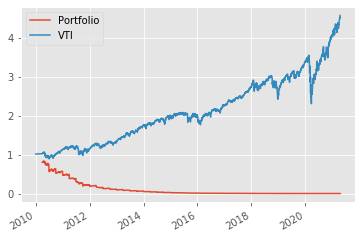

In [56]:
def select_assets(date):
    assets = SALESA[:date].iloc[-1].nlargest(100).index
    return assets


def select_weights(date, assets):     
    weights = pd.Series(1/len(assets), index=assets) 
    return weights  


portfolio, weights, trades = run_backtest('quarter', '2010-1-1')

t = portfolio.to_frame('Portfolio').join(vti.pct_change())
t.add(1).cumprod().plot()